In [1]:
%matplotlib inline
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cpu'

We use here capture to suppress output that could disclose author information. If you run this cell, you can of course delete the capture command to get some feedback whether the cloning worked.

In [2]:
%%capture
!git clone https://github.com/kynehc/clone_anonymous_github.git
%cd clone_anonymous_github
!python3 download.py --url https://anonymous.4open.science/r/GaussNetworks-A7E7/ --dir gauss_nets/
%cd gauss_nets
!ls

In [3]:
!git pull

Already up to date.


In [4]:
import train
from train.models import *
from train import *
from train.layers import *
from train.loss import *
from train.optimization import Optimizer
from attack import FGSM

In [5]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor()])

testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes for motivating picture
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

==> Preparing data..


In [6]:
path = "checkpoint/"
def load_net(name,dim_embedding,classifier):
    net = LeNet(dim_embedding,classifier)
    checkpoint = torch.load(path+name+'.t7',map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    net.eval()
    print('LeNet ACC:',checkpoint['acc'])
    return net

In [7]:
d=10

In [8]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

In [9]:
net_dict={}
net_dict["sm"] = load_net('MNISTLeNetLinear',d,nn.Linear(in_features = d, out_features = c))
net_dict["duq"] = load_net('MNISTLeNetGauss_DUQ',d,Gauss_DUQ(in_features = d, out_features = c, gamma=1))
net_dict["ga"] = load_net('MNISTLeNetGauss',d,Gauss(in_features = d, out_features = c,gamma=1))

LeNet ACC: tensor(99.2600)
LeNet ACC: tensor(98.4767)
LeNet ACC: tensor(99.3000)


In [10]:
net_dict["sm"] = nn.Sequential(Normalize(mean=[0.5], std=[1]), net_dict["sm"])
net_dict["ga"] = nn.Sequential(Normalize(mean=[0.5], std=[1]), net_dict["ga"])
net_dict["duq"] = nn.Sequential(Normalize(mean=[0.5], std=[1]), net_dict["duq"])
for net_key in net_dict.keys():
    net_dict[net_key]=net_dict[net_key].eval()

In [11]:
criterion_dict = {}
criterion_dict["sm"] = CE_Loss(net_dict["sm"][1].classifier, c, device)
criterion_dict["ga"] = CE_GALoss(net_dict["ga"][1].classifier, c, device)
criterion_dict["duq"] = BCE_DUQLoss(net_dict["duq"][1].classifier, c, device)

In [12]:
# Plot several examples of adversarial samples at each epsilon
def plot_adv(net_keys, min_conf=0.1):
    plt.figure(figsize=(18,7))
    p=0
    for net_key in net_keys:
        net_dict[net_key].eval()
        criterion = criterion_dict[net_key]
        embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
        conf_pert, pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
        conf, pred = criterion.conf(embed(inputs)).max(1)
        attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>min_conf)
        examples = examples_dict[net_key][attack_success]
        p=int(np.ceil(p/10)*10)
        for j in range(min(examples.shape[0],10)):
            p+=1
            plt.subplot(len(net_keys),10,p)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title("{} {} ({:.2f})".format(net_key,classes[pred_pert[attack_success][j]], conf_pert[attack_success][j]),fontsize = 20)
            plt.imshow(net_dict[net_key][0](examples[j]).squeeze().detach().numpy(), cmap="gray")         
    plt.tight_layout()
    plt.show()

In [13]:
inputs, targets = next(iter(testloader))
class Seq_normalize(nn.Module):
    def __init__(self, normalizer, net):
        super(Seq_normalize, self).__init__()
        self.net=net
        self.normalizer = normalizer
    def forward(self, inputs):
        return self.net(self.normalizer(inputs))
    def embed(self,inputs):
        return self.net.embed(self.normalizer(inputs))

In [14]:
optimizer = Optimizer(None, testloader, device)
for net_key in net_dict.keys():
    print(net_key)
    (acc,conf) = optimizer.test_acc(Seq_normalize(net_dict[net_key][0],net_dict[net_key][1]),criterion_dict[net_key], testloader)

sm
Loss: 0.024 | Acc: 99.260% (9926/10000) | Conf 99.35
duq
Loss: 0.031 | Acc: 98.420% (9842/10000) | Conf 86.72
ga
Loss: 0.185 | Acc: 99.300% (9930/10000) | Conf 92.59


# Attack

In [15]:
!pip install --upgrade git+https://github.com/BorealisAI/advertorch.git

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/BorealisAI/advertorch.git to /private/var/folders/3h/v9rwrxsj02n4bvnfdw3s81vc0000gn/T/pip-req-build-n7oylw9j
  Running command git clone --filter=blob:none --quiet https://github.com/BorealisAI/advertorch.git /private/var/folders/3h/v9rwrxsj02n4bvnfdw3s81vc0000gn/T/pip-req-build-n7oylw9j
  Resolved https://github.com/BorealisAI/advertorch.git to commit e063e341c87d9a621ae1a8f72c3507d5ea5bd327
  Preparing metadata (setup.py) ... done
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Carlini & Wagner Attack

In [16]:
from advertorch.attacks import CarliniWagnerL2Attack
examples_dict={}
for net_key in net_dict.keys():
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed, criterion.classifier)
    attack = CarliniWagnerL2Attack(embed, c, confidence=-np.log(0.2), max_iterations=100 )    
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())

CE_Loss 17 0.7617665529251099
BCE_DUQLoss 0 nan
CE_GALoss 0 nan


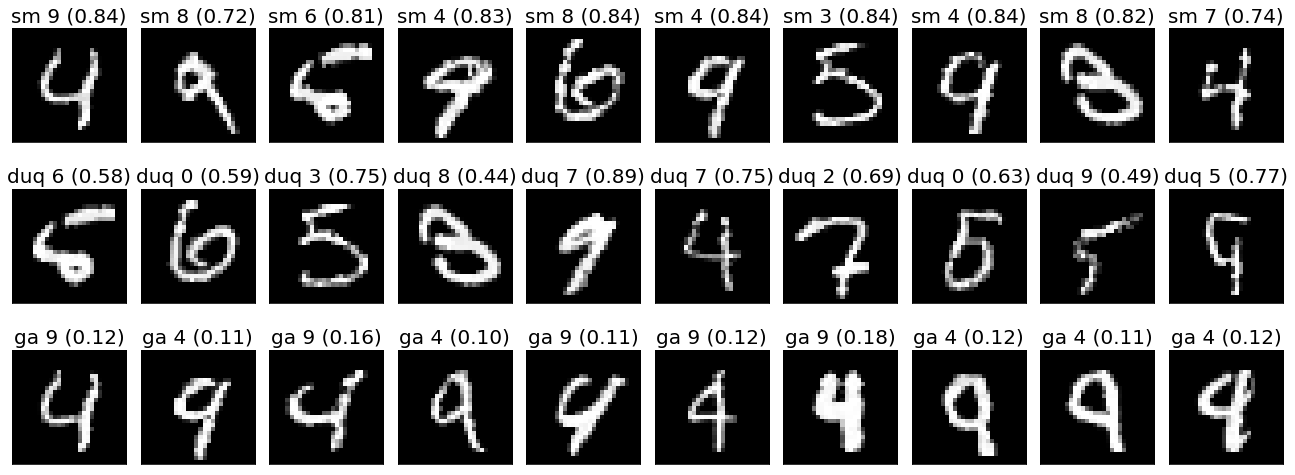

In [17]:
plot_adv(net_dict.keys())

# One Pixel Attack

In [18]:
from advertorch.attacks import SinglePixelAttack
examples_dict={}
for net_key in net_dict.keys():
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
    attack = SinglePixelAttack(embed, loss_fn=criterion, max_pixels=1)
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())

/opt/homebrew/lib/python3.9/site-packages/advertorch/attacks/localsearch.py:62: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col = pixels[ii] // x.shape[2]


CE_Loss 0 nan
BCE_DUQLoss 0 nan
CE_GALoss 0 nan


In [19]:
plot_adv(net_dict.keys())

<Figure size 1296x504 with 0 Axes>

# FGSM attack

In [22]:
from advertorch.attacks import GradientSignAttack
examples_dict={}
for net_key in net_dict.keys():
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
    attack = GradientSignAttack(embed, eps=0.1, loss_fn=criterion)
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())

CE_Loss 116 0.7504289746284485
BCE_DUQLoss 377 0.6668139100074768
CE_GALoss 40 0.44280806183815


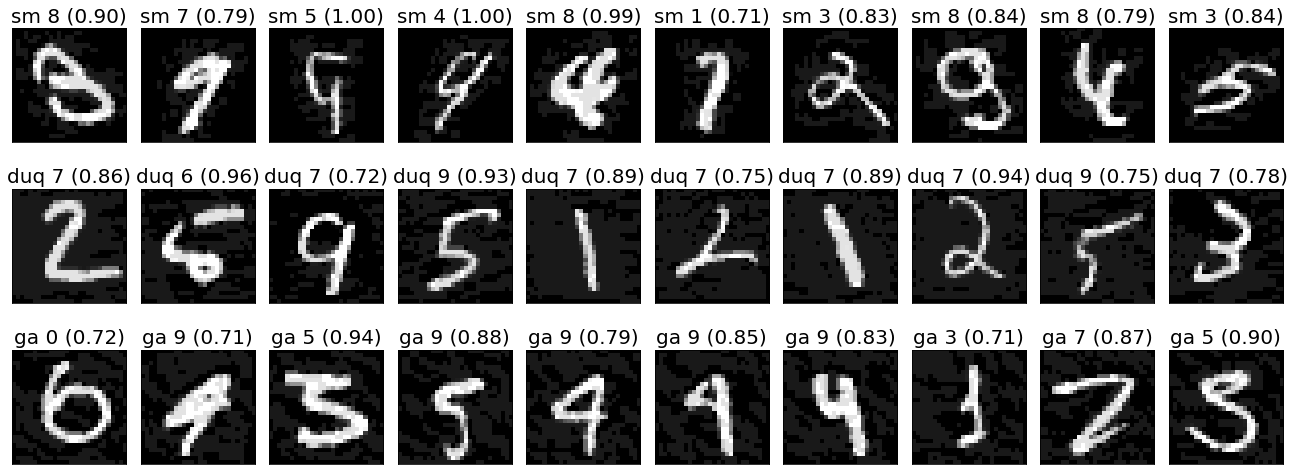

In [23]:
plot_adv(net_dict.keys(),min_conf=0.7)

# Linf PGD Attack

In [24]:
from advertorch.attacks import LinfPGDAttack
examples_dict={}
for net_key in net_dict.keys():
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
    attack = LinfPGDAttack(embed, loss_fn=criterion, eps=0.1, nb_iter=40, eps_iter=0.01)
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())

CE_Loss 230 0.8028595447540283
BCE_DUQLoss 923 0.9133168458938599
CE_GALoss 197 0.5162397027015686


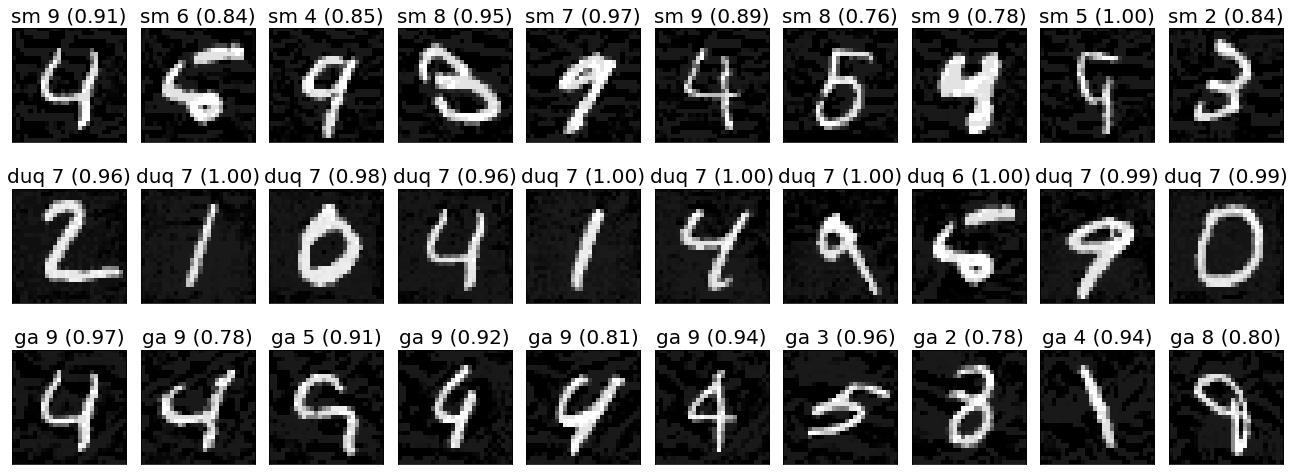

In [25]:
plot_adv(net_dict.keys(),min_conf=0.7)

# L2PGDAttack

In [26]:
from advertorch.attacks import L2PGDAttack
examples_dict={}
for net_key in net_dict.keys():   
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
    attack = L2PGDAttack(embed, loss_fn=criterion, eps=0.1, nb_iter=40, eps_iter=0.01)
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())

CE_Loss 5 0.537592887878418
BCE_DUQLoss 4 0.22459730505943298
CE_GALoss 0 nan


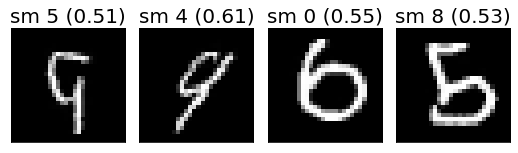

In [27]:
plot_adv(net_dict.keys(),min_conf=0.5)

# Sparse L1 Descent Attack

In [ ]:
from advertorch.attacks import SparseL1DescentAttack
adv_dict, examples_dict={},{}
for net_key in net_dict.keys():
    net_dict[net_key].eval()
    criterion = criterion_dict[net_key]
    embed = nn.Sequential(net_dict[net_key][0],net_dict[net_key][1].embed)
    attack = SparseL1DescentAttack(embed, eps=0.3, loss_fn=criterion)
    examples_dict[net_key]= attack.perturb(inputs, targets)
    conf_pert,pred_pert = criterion.conf(embed(examples_dict[net_key])).max(1)
    conf,pred = criterion.conf(embed(inputs)).max(1)
    attack_success = (targets != pred_pert) & (targets==pred) & (conf_pert>0.1)
    print(criterion.__class__.__name__,(attack_success).sum().item(),conf_pert[attack_success].mean().item())